# Spearman Comparison

Questions:
1. Where do embeddings (Word2Vec, decontext embedding) predict differnt similarity than humans? (explains why correlation is not 1) 
2. Where do decontext embedding perform different than static Word2Vec embeddings? (explains different correlation of W2V and decontext)


In [1]:
from os.path import join as pjoin
import sys 
sys.path.append('/home/hhansen/DecontextEmbeddings')
import os 
os.environ['EMBEDDING_EVALUATION_DATA_PATH'] = '/home/hhansen/DecontextEmbeddings/helpers/embedding_evaluation/data/'
DATA_DIR = '/home/hhansen/DecontextEmbeddings/data'
os.environ['DATA_DIR'] = DATA_DIR
FIGURE_OUTPUT_DIR = pjoin(DATA_DIR, 'figures', 'similarity_rating_distribution')

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

from helpers.embedding_evaluation.evaluate import Evaluation as wordsim_evaluate
from helpers.embedding_evaluation.data import read_wordsim_embeddings
from helpers.things_evaluation.evaluate import read_embeddings, load_behav, load_sorting, match_behv_sim, evaluate as run_evaluation
from helpers.data import yield_static_data, load_simlex, load_wordsim, load_things_database
from helpers.intersection import get_intersection_words
from helpers.similarity_values import get_ranks, calc_diffs, get_spose_matrix, rsa_matrix_to_pair_list

from scipy.stats import spearmanr, pearsonr

#from transformers import BertTokenizerFast
#pretrained_weights = 'bert-base-uncased'
#tokenizer = BertTokenizerFast.from_pretrained(
#                pretrained_weights, padding_side='right', model_max_length=512)


/home/hhansen/decon/decon_env/DecontextEmbeddings/data


In [2]:
def get_table_with_rank_diffs(df):
    rank_col = 'embedding_rank_bert'
    rank_diff_col = 'di^2_decontext_bert'
    embedding_sim_col = 'Cosine Similarities (BERT)'

    mismatch = df.sort_values(rank_diff_col, ascending=False).head(20)
    return mismatch[['word1', 'word2', 'Human Judgement', embedding_sim_col]]


In [3]:
def plot(df, title, alpha, size):
    #df = df.sample(100000)
    sns.pairplot(df[['Human Judgement', 'Cosine Similarities (Word2Vec)', 'Cosine Similarities (GPT-2)', 'Cosine Similarities (BERT)']], plot_kws={'alpha': alpha, 's': size, 'rasterized': True})
    plt.savefig(f'things_correlations_{title}.pdf', bbox_inches='tight')

In [4]:
def remove_not_in_vocab(matching_words):
    from transformers import BertTokenizerFast
    pretrained_weights = 'bert-base-uncased'
    tokenizer = BertTokenizerFast.from_pretrained(
                pretrained_weights, padding_side='right', model_max_length=512)

    words_not_in_vocab = []
    df = pd.read_csv('../../../../data/thinga/things_concepts.tsv', sep='\t')
    for row in df.iterrows():
        word = row[1]['Word']
        things_id = row[1]['uniqueID']
        if word not in tokenizer.vocab:
            words_not_in_vocab.append(things_id)

    return matching_words.difference(words_not_in_vocab)

In [5]:
def remove_homonyms(matching_words):
    homonymns = []
    df = pd.read_csv('../../../../data/thinga/things_concepts.tsv', sep='\t')
    for row in df.iterrows():
        things_id = row[1]['uniqueID']
        if '1' in things_id or '2' in things_id or '3' in things_id:
            homonymns.append(row[1]['Word'])

    return matching_words.difference(homonymns)

# THINGS

In [6]:
things_df = rsa_matrix_to_pair_list(get_spose_matrix())
things_df = things_df.rename(columns={'sim': 'Human Judgement'})

In [7]:
matching = 'word'

all_matching_words = get_intersection_words(None, corpus_folder='wikidumps', folder='thinga', matching=matching)
#matching_words_tokenizer = remove_not_in_vocab(all_matching_words)
#matching_words_no_homonyms = remove_homonyms(all_matching_words)

('w2v', '/home/hhansen/decon/decon_env/data/thinga/static/w2v/word2vec-google-news-300/embeddings.txt', 'word')
('glove', '/home/hhansen/decon/decon_env/data/thinga/static/glove/glove-wiki-gigaword-300/embeddings.txt', 'word')
('deconf', '/home/hhansen/decon/decon_env/data/thinga/static/deconf/embeddings.txt', 'synset')
Number of words intersection: 1522


## Pretrained
Scatterplots of similarity ratings -> visualize correlation

In [8]:
def get_df(things_df, matching_words):    
    embedding_path = f'/home/hhansen/decon/decon_env/data/thinga/wikidumps/decontext/bert-base/12/{matching}/mean/all/decontext.txt'
    p, s, sim_matrix, v = run_evaluation(embedding_path, matching, matching_words=matching_words)
    things_decontext_df = rsa_matrix_to_pair_list(sim_matrix).rename(columns={'sim': 'Cosine Similarities (BERT)'})

    embedding_w2v_path = f'{EMBEDDING_DATA_DIR}/thinga/static/w2v/word2vec-google-news-300/embeddings.txt'
    p, s, sim_matrix_w2v, v = run_evaluation(embedding_w2v_path, 'word', matching_words=matching_words)
    things_w2v_df = rsa_matrix_to_pair_list(sim_matrix_w2v).rename(columns={'sim': 'Cosine Similarities (Word2Vec)'})

    embedding_path = f'/home/hhansen/decon/decon_env/data/thinga/wikidumps/decontext/gpt-2/12/{matching}/mean/all/decontext.txt'
    p, s, sim_matrix_gpt, v = run_evaluation(embedding_path, matching, matching_words=matching_words)
    things_gpt_df = rsa_matrix_to_pair_list(sim_matrix_gpt).rename(columns={'sim': 'Cosine Similarities (GPT-2)'})

    
    things_merged_df = things_df.merge(things_decontext_df, on=['word1', 'word2']).merge(things_w2v_df, on=['word1', 'word2']).merge(things_gpt_df, on=['word1', 'word2'])

    things_merged_df = get_ranks(things_merged_df)
    #things_merged_df = calc_diffs(things_merged_df)

    return things_merged_df

In [9]:
pretrained_df = get_df(things_df, all_matching_words)

Index(['aardvark', 'abacus', 'accordion', 'acorn', 'airbag', 'airplane',
       'album', 'alligator', 'almond', 'aloe',
       ...
       'wrist', 'xylophone', 'yacht', 'yak', 'yogurt', 'yoke', 'yolk', 'zebra',
       'zipper', 'zucchini'],
      dtype='object', name='things_id', length=1522)
Index(['aardvark', 'abacus', 'accordion', 'acorn', 'airbag', 'airplane',
       'album', 'alligator', 'almond', 'aloe',
       ...
       'wrist', 'xylophone', 'yacht', 'yak', 'yogurt', 'yoke', 'yolk', 'zebra',
       'zipper', 'zucchini'],
      dtype='object', name='things_id', length=1522)
Index(['aardvark', 'abacus', 'accordion', 'acorn', 'airbag', 'airplane',
       'album', 'alligator', 'almond', 'aloe',
       ...
       'wrist', 'xylophone', 'yacht', 'yak', 'yogurt', 'yoke', 'yolk', 'zebra',
       'zipper', 'zucchini'],
      dtype='object', name='things_id', length=1522)


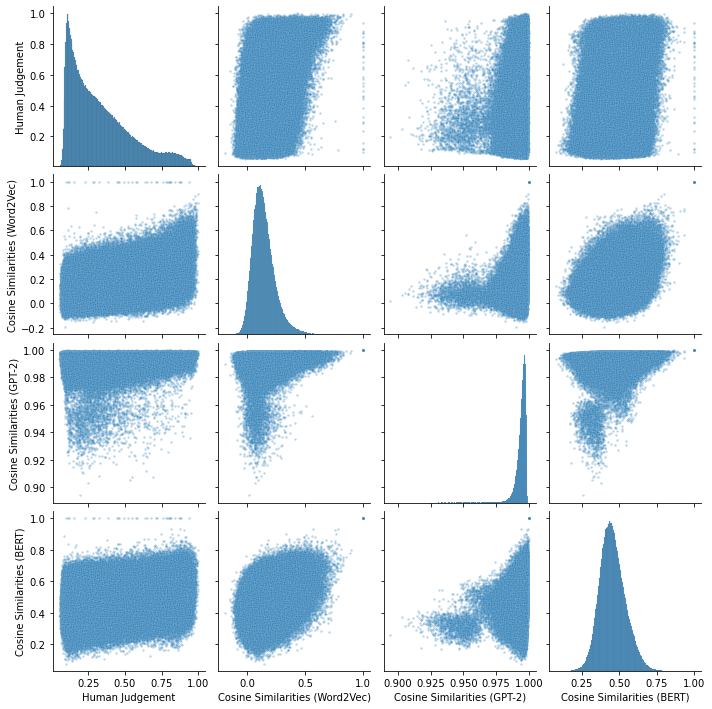

In [10]:
plot(pretrained_df, 'pretrained', 0.3, 6)

In [11]:
df = get_table_with_rank_diffs(pretrained_df).style.hide_index()
df

word1,word2,Human Judgement,Cosine Similarities (BERT)
piglet,ratchet,0.073836,0.700498
gyro,periscope,0.072988,0.695925
cornucopia,unicycle,0.079575,0.724748
beaver,cardinal,0.947721,0.259969
scaffold,scallop,0.081665,0.734396
cardinal,vulture,0.963116,0.269176
target,volleyball,0.949667,0.266281
cornucopia,tripod,0.077458,0.688757
gyro,tripod,0.083717,0.760370
blouse,tag,0.923871,0.247798


In [12]:
print(df.to_latex())

\begin{tabular}{llrr}
{word1} & {word2} & {Human Judgement} & {Cosine Similarities (BERT)} \\
piglet & ratchet & 0.073836 & 0.700498 \\
gyro & periscope & 0.072988 & 0.695925 \\
cornucopia & unicycle & 0.079575 & 0.724748 \\
beaver & cardinal & 0.947721 & 0.259969 \\
scaffold & scallop & 0.081665 & 0.734396 \\
cardinal & vulture & 0.963116 & 0.269176 \\
target & volleyball & 0.949667 & 0.266281 \\
cornucopia & tripod & 0.077458 & 0.688757 \\
gyro & tripod & 0.083717 & 0.760370 \\
blouse & tag & 0.923871 & 0.247798 \\
eggbeater & seagull & 0.076629 & 0.682493 \\
cobra & moth & 0.914561 & 0.233755 \\
gyro & gyroscope & 0.084651 & 0.889926 \\
beetle & cobra & 0.923641 & 0.251424 \\
jackhammer & meatball & 0.081266 & 0.699798 \\
beetle & earwig & 0.951322 & 0.273644 \\
jackhammer & pancake & 0.079690 & 0.689060 \\
sweater & tag & 0.938107 & 0.267384 \\
skunk & whisk & 0.071878 & 0.669830 \\
chisel & pheasant & 0.074896 & 0.672613 \\
\end{tabular}



## Retrained
Effect of retraining on the similarity ratings

In [8]:
test_words = list(pd.read_csv('../fine_tune/val_words.txt', header=None, names=['words'])['words'])

In [9]:
def get_ranked_df(path):
    p, s, sim_matrix, v = run_evaluation(path, matching, matching_words=test_words)
    df = rsa_matrix_to_pair_list(sim_matrix).rename(columns={'sim': 'Cosine Similarities (BERT)'})
    df = df.merge(things_df, on=['word1', 'word2'])
    return get_ranks(df)

In [22]:
embedding_path = f'/home/hhansen/decon/decon_env/data_fine_tune/things/wikidumps/decontext/bert-base/12/{matching}/mean/all/constrastive_loss.txt'
finetuned_df = get_ranked_df(embedding_path)

Index(['aircraft_carrier', 'album', 'almond', 'altar', 'anvil', 'baby',
       'baklava', 'bamboo', 'baseball_bat', 'batter',
       ...
       'vase', 'vent', 'wetsuit', 'whale', 'wheel', 'whistle', 'window',
       'wine_bottle', 'wrapping_paper', 'zebra'],
      dtype='object', name='things_id', length=216)


In [23]:
embedding_path = f'/home/hhansen/decon/decon_env/data/thinga/wikidumps/decontext/bert-base/12/{matching}/mean/all/decontext.txt'
test_pretrained_df = get_ranked_df(embedding_path)

Index(['aircraft_carrier', 'album', 'almond', 'altar', 'anvil', 'baby',
       'baklava', 'bamboo', 'baseball_bat', 'batter',
       ...
       'vase', 'vent', 'wetsuit', 'whale', 'wheel', 'whistle', 'window',
       'wine_bottle', 'wrapping_paper', 'zebra'],
      dtype='object', name='things_id', length=216)


In [27]:
embedding_path = f'/home/hhansen/decon/decon_env/data_fine_tune/things/wikidumps/decontext/bert-base/12/{matching}/mean/all/new.txt'
finetuned_df_sqrt = get_ranked_df(embedding_path)

embedding_path = f'/home/hhansen/decon/decon_env/data_fine_tune/things/wikidumps/decontext/bert-base/12/{matching}/mean/all/2minus.txt'
finetuned_df_2 = get_ranked_df(embedding_path)

embedding_path = f'/home/hhansen/decon/decon_env/data_fine_tune/things/wikidumps/decontext/bert-base/12/{matching}/mean/all/cs_niklas.txt'
finetuned_df_3 = get_ranked_df(embedding_path)

embedding_path = f'/home/hhansen/decon/decon_env/data_fine_tune/things/wikidumps/decontext/bert-base/12/{matching}/mean/all/cs_niklas_2.txt'
finetuned_df_4 = get_ranked_df(embedding_path)

Index(['aircraft_carrier', 'album', 'almond', 'altar', 'anvil', 'baby',
       'baklava', 'bamboo', 'baseball_bat', 'batter',
       ...
       'vase', 'vent', 'wetsuit', 'whale', 'wheel', 'whistle', 'window',
       'wine_bottle', 'wrapping_paper', 'zebra'],
      dtype='object', name='things_id', length=216)


In [33]:
embedding_path = f'/home/hhansen/decon/decon_env/data_fine_tune/things/wikidumps/decontext/bert-base/12/{matching}/mean/all/normal_cs_regularized.txt'
reg = get_ranked_df(embedding_path) 

Index(['aircraft_carrier', 'album', 'almond', 'altar', 'anvil', 'baby',
       'baklava', 'bamboo', 'baseball_bat', 'batter',
       ...
       'vase', 'vent', 'wetsuit', 'whale', 'wheel', 'whistle', 'window',
       'wine_bottle', 'wrapping_paper', 'zebra'],
      dtype='object', name='things_id', length=216)


In [34]:
embedding_path = f'/home/hhansen/decon/decon_env/data_fine_tune/things/wikidumps/decontext/bert-base/12/{matching}/mean/all/normal_cs_regularized_dropout.txt'
reg_drop = get_ranked_df(embedding_path) 

Index(['aircraft_carrier', 'album', 'almond', 'altar', 'anvil', 'baby',
       'baklava', 'bamboo', 'baseball_bat', 'batter',
       ...
       'vase', 'vent', 'wetsuit', 'whale', 'wheel', 'whistle', 'window',
       'wine_bottle', 'wrapping_paper', 'zebra'],
      dtype='object', name='things_id', length=216)


In [ ]:
embedding_path = f'/home/hhansen/decon/decon_env/data_fine_tune/things/wikidumps/decontext/bert-base/12/{matching}/mean/all/normal_cs_regularized_dropout.txt'
reg_drop = get_ranked_df(embedding_path) 

In [36]:
embedding_path = f'/home/hhansen/decon/decon_env/data_fine_tune/things/wikidumps/decontext/bert-base/12/{matching}/mean/all/mse_new.txt'
mse_new = get_ranked_df(embedding_path) 

Index(['aircraft_carrier', 'album', 'almond', 'altar', 'anvil', 'baby',
       'baklava', 'bamboo', 'baseball_bat', 'batter',
       ...
       'vase', 'vent', 'wetsuit', 'whale', 'wheel', 'whistle', 'window',
       'wine_bottle', 'wrapping_paper', 'zebra'],
      dtype='object', name='things_id', length=216)


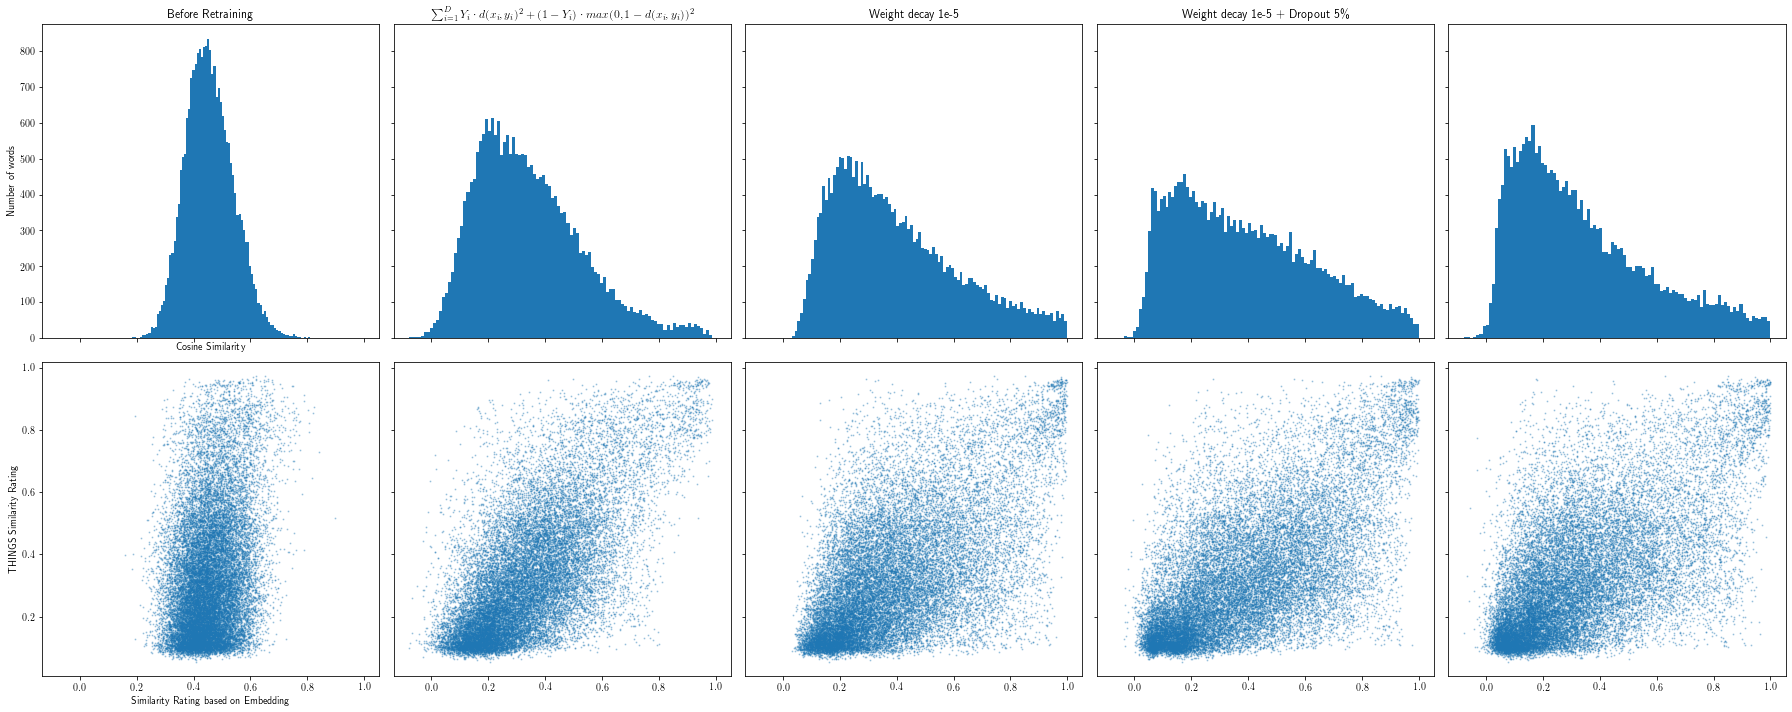

In [37]:
fig, axes = plt.subplots(2,5, figsize=(25, 10), sharey='row', sharex=True)
plt.rcParams['text.usetex'] = True

axes[0][0].set_title('Before Retraining')

axes[0][1].set_title(r'$\sum_{i=1}^{D} Y_i \cdot d(x_i,y_i)^2 + (1-Y_i) \cdot max(0, 1 - d(x_i,y_i))^2$')
axes[0][2].set_title('Weight decay 1e-5')
axes[0][3].set_title('Weight decay 1e-5 + Dropout 5\%')


axes[0][0].set_ylabel('Number of words')
axes[0][0].set_xlabel('Cosine Similarity')


axes[0][0].hist(test_pretrained_df['Cosine Similarities (BERT)'], bins=100)
axes[0][1].hist(finetuned_df['Cosine Similarities (BERT)'], bins=100)
axes[0][2].hist(reg['Cosine Similarities (BERT)'], bins=100)
axes[0][3].hist(reg_drop['Cosine Similarities (BERT)'], bins=100)
axes[0][4].hist(mse_new['Cosine Similarities (BERT)'], bins=100)

axes[1][0].scatter(test_pretrained_df['Cosine Similarities (BERT)'],test_pretrained_df['Human Judgement'], alpha=0.3, s=1, rasterized=True)
axes[1][1].scatter(finetuned_df['Cosine Similarities (BERT)'], finetuned_df['Human Judgement'], alpha=0.3, s=1, rasterized=True)
axes[1][2].scatter(reg['Cosine Similarities (BERT)'], reg['Human Judgement'], alpha=0.3, s=1, rasterized=True)
axes[1][3].scatter(reg_drop['Cosine Similarities (BERT)'], reg_drop['Human Judgement'], alpha=0.3, s=1, rasterized=True)
axes[1][4].scatter(mse_new['Cosine Similarities (BERT)'], mse_new['Human Judgement'], alpha=0.3, s=1, rasterized=True)


axes[1][0].set_xlabel('Similarity Rating based on Embedding')
axes[1][0].set_ylabel('THINGS Similarity Rating')

plt.tight_layout()
plt.savefig('similarity_scatter_after_finetuning.pdf', bbox_inches='tight')


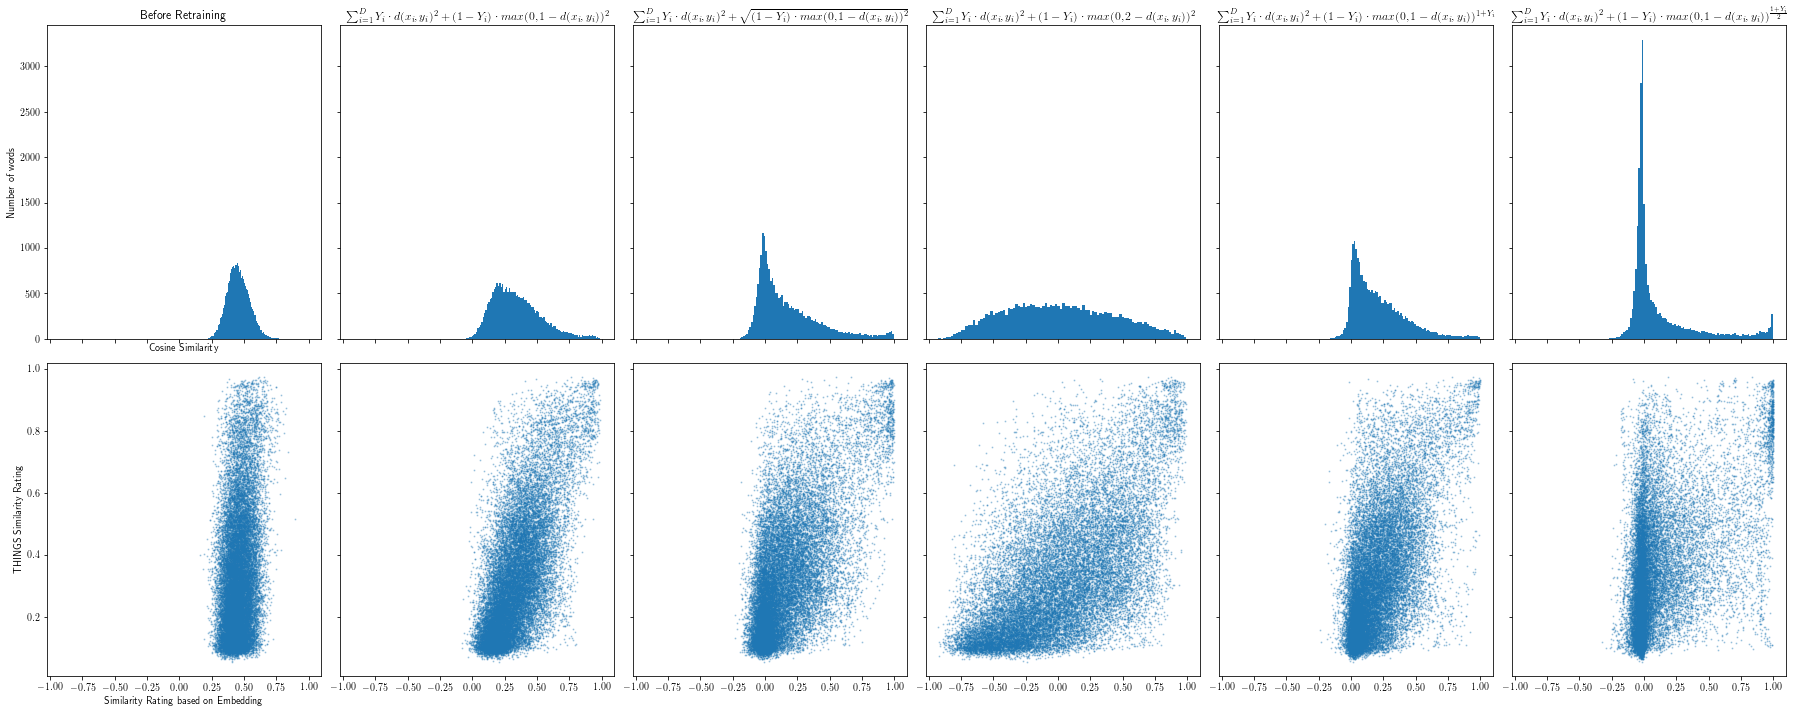

In [68]:
fig, axes = plt.subplots(2,6, figsize=(25, 10), sharey='row', sharex=True)
plt.rcParams['text.usetex'] = True

axes[0][0].set_title('Before Retraining')

axes[0][1].set_title(r'$\sum_{i=1}^{D} Y_i \cdot d(x_i,y_i)^2 + (1-Y_i) \cdot max(0, 1 - d(x_i,y_i))^2$')
axes[0][2].set_title(r'$\sum_{i=1}^{D} Y_i \cdot d(x_i,y_i)^2 + \sqrt{(1-Y_i) \cdot max(0, 1 - d(x_i,y_i))^2}$')
axes[0][3].set_title(r'$\sum_{i=1}^{D} Y_i \cdot d(x_i,y_i)^2 + (1-Y_i) \cdot max(0, 2 - d(x_i,y_i))^2$')
axes[0][4].set_title(r'$\sum_{i=1}^{D} Y_i \cdot d(x_i,y_i)^2 + (1-Y_i) \cdot max(0, 1 - d(x_i,y_i))^{1+Y_i}$')
axes[0][5].set_title(r'$\sum_{i=1}^{D} Y_i \cdot d(x_i,y_i)^2 + (1-Y_i) \cdot max(0, 1 - d(x_i,y_i))^{\frac{1+Y_i}{2}}$')


axes[0][0].set_ylabel('Number of words')
axes[0][0].set_xlabel('Cosine Similarity')


axes[0][0].hist(test_pretrained_df['Cosine Similarities (BERT)'], bins=100)
axes[0][1].hist(finetuned_df['Cosine Similarities (BERT)'], bins=100)
axes[0][2].hist(finetuned_df_sqrt['Cosine Similarities (BERT)'], bins=100)
axes[0][3].hist(finetuned_df_2['Cosine Similarities (BERT)'], bins=100)
axes[0][4].hist(finetuned_df_3['Cosine Similarities (BERT)'], bins=100)
axes[0][5].hist(finetuned_df_4['Cosine Similarities (BERT)'], bins=100)

axes[1][0].scatter(test_pretrained_df['Cosine Similarities (BERT)'],test_pretrained_df['Human Judgement'], alpha=0.3, s=1, rasterized=True)
axes[1][1].scatter(finetuned_df['Cosine Similarities (BERT)'], finetuned_df['Human Judgement'], alpha=0.3, s=1, rasterized=True)
axes[1][2].scatter(finetuned_df_sqrt['Cosine Similarities (BERT)'], finetuned_df_sqrt['Human Judgement'], alpha=0.3, s=1, rasterized=True)
axes[1][3].scatter(finetuned_df_2['Cosine Similarities (BERT)'], finetuned_df_2['Human Judgement'], alpha=0.3, s=1, rasterized=True)
axes[1][4].scatter(finetuned_df_3['Cosine Similarities (BERT)'], finetuned_df_3['Human Judgement'], alpha=0.3, s=1, rasterized=True)
axes[1][5].scatter(finetuned_df_4['Cosine Similarities (BERT)'], finetuned_df_4['Human Judgement'], alpha=0.3, s=1, rasterized=True)


axes[1][0].set_xlabel('Similarity Rating based on Embedding')
axes[1][0].set_ylabel('THINGS Similarity Rating')

plt.tight_layout()
plt.savefig('similarity_scatter_after_finetuning.pdf', bbox_inches='tight')


In [17]:
df = get_table_with_rank_diffs(finetuned_df).style.hide_index()

In [18]:
df

word1,word2,Human Judgement,Cosine Similarities (BERT)
flower,parachute,0.720796,0.011849
batter,buffet,0.796209,0.086989
fireplace,hookah,0.673423,0.016131
harp,hookah,0.704696,0.058587
sarcophagus,skull,0.634871,-0.006021
dolly,piglet,0.096305,0.649949
frisbee,sweet_potato,0.110300,0.794303
batter,meatloaf,0.812553,0.115237
batter,sausage,0.755848,0.102221
frisbee,green_beans,0.112885,0.801271


In [19]:
print(df.to_latex())

\begin{tabular}{llrr}
{word1} & {word2} & {Human Judgement} & {Cosine Similarities (BERT)} \\
flower & parachute & 0.720796 & 0.011849 \\
batter & buffet & 0.796209 & 0.086989 \\
fireplace & hookah & 0.673423 & 0.016131 \\
harp & hookah & 0.704696 & 0.058587 \\
sarcophagus & skull & 0.634871 & -0.006021 \\
dolly & piglet & 0.096305 & 0.649949 \\
frisbee & sweet_potato & 0.110300 & 0.794303 \\
batter & meatloaf & 0.812553 & 0.115237 \\
batter & sausage & 0.755848 & 0.102221 \\
frisbee & green_beans & 0.112885 & 0.801271 \\
dryer & potpourri & 0.109047 & 0.731696 \\
chisel & grits & 0.085449 & 0.581435 \\
hookah & mandolin & 0.669893 & 0.088446 \\
cuckoo_clock & sled & 0.645062 & 0.076710 \\
frisbee & sausage & 0.110964 & 0.680746 \\
mouth & squeegee & 0.595774 & 0.052974 \\
cash_machine & potpourri & 0.104216 & 0.623480 \\
batter & smoothie & 0.807225 & 0.135740 \\
butter & counter & 0.579469 & 0.051220 \\
hole & skeleton & 0.611256 & 0.081755 \\
\end{tabular}



## Rank Difference before-after retraining

In [20]:
finetuned_df = finetuned_df.rename(columns={'di^2_decontext_bert': 'rank_difference_after_retrain', 'Cosine Similarities (BERT)': 'Similarity After Retrain'})
finetuned_df[['word1', 'word2', 'rank_difference_after_retrain']]

,word1,word2,rank_difference_after_retrain
0,aircraft_carrier,album,1373584.0
1,aircraft_carrier,almond,10530025.0
2,aircraft_carrier,altar,39853969.0
3,aircraft_carrier,anvil,117115684.0
4,aircraft_carrier,baby,10259209.0
...,...,...,...
23215,window,wrapping_paper,1232100.0
23216,window,zebra,5303809.0
23217,wine_bottle,wrapping_paper,2102500.0
23218,wine_bottle,zebra,11397376.0


In [21]:
test_pretrained_df = test_pretrained_df.rename(columns={'di^2_decontext_bert': 'rank_difference_before_retrain', 'Cosine Similarities (BERT)': 'Similarity Before Retrain'})
test_pretrained_df[['word1', 'word2', 'rank_difference_before_retrain']]

,word1,word2,rank_difference_before_retrain
0,aircraft_carrier,album,15642025.0
1,aircraft_carrier,almond,19838116.0
2,aircraft_carrier,altar,40742689.0
3,aircraft_carrier,anvil,8225424.0
4,aircraft_carrier,baby,116726416.0
...,...,...,...
23215,window,wrapping_paper,361.0
23216,window,zebra,5216656.0
23217,wine_bottle,wrapping_paper,10758400.0
23218,wine_bottle,zebra,38887696.0


In [40]:
df_before_after_retrain = finetuned_df.merge(test_pretrained_df, on=['word1', 'word2'])
df_before_after_retrain

,word1,word2,Similarity After Retrain,Human Judgement_x,human_rank_x,embedding_rank_bert_x,rank_difference_after_retrain,Similarity Before Retrain,Human Judgement_y,human_rank_y,embedding_rank_bert_y,rank_difference_before_retrain
0,aircraft_carrier,album,0.343471,0.290683,11804.0,12976.0,1373584.0,0.416892,0.290683,11804.0,7849.0,15642025.0
1,aircraft_carrier,almond,0.160560,0.086805,302.0,3547.0,10530025.0,0.386356,0.086805,302.0,4756.0,19838116.0
2,aircraft_carrier,altar,0.497569,0.305879,12472.0,18785.0,39853969.0,0.400072,0.305879,12472.0,6089.0,40742689.0
3,aircraft_carrier,anvil,0.272905,0.594034,20388.0,9566.0,117115684.0,0.513200,0.594034,20388.0,17520.0,8225424.0
4,aircraft_carrier,baby,0.200702,0.118144,2498.0,5701.0,10259209.0,0.467041,0.118144,2498.0,13302.0,116726416.0
...,...,...,...,...,...,...,...,...,...,...,...,...
23215,window,wrapping_paper,0.415942,0.440952,17169.0,16059.0,1232100.0,0.509085,0.440952,17169.0,17188.0,361.0
23216,window,zebra,0.152704,0.163467,5507.0,3204.0,5303809.0,0.416378,0.163467,5507.0,7791.0,5216656.0
23217,wine_bottle,wrapping_paper,0.455351,0.511038,18960.0,17510.0,2102500.0,0.608991,0.511038,18960.0,22240.0,10758400.0
23218,wine_bottle,zebra,0.025751,0.133351,3537.0,161.0,11397376.0,0.434681,0.133351,3537.0,9773.0,38887696.0


In [41]:
df_before_after_retrain['rank_diff_before_and_after_retrain'] = df_before_after_retrain.apply(lambda row: row.rank_difference_before_retrain - row.rank_difference_after_retrain, axis=1)



In [42]:
bad_updates = df_before_after_retrain.sort_values('rank_diff_before_and_after_retrain', ascending=True).head(20)
bad_updates[['word1', 'word2', 'Human Judgement_x', 'Similarity Before Retrain', 'Similarity After Retrain']]

,word1,word2,Human Judgement_x,Similarity Before Retrain,Similarity After Retrain
21636,sarcophagus,skull,0.634871,0.533456,-0.006021
12139,frisbee,sausage,0.110964,0.325588,0.680746
12099,frisbee,olive,0.131535,0.392518,0.748010
11218,eye_patch,recliner,0.538012,0.489641,0.035459
9151,counter,smoothie,0.577887,0.504135,0.087469
9136,counter,sauce,0.576561,0.482519,0.065043
11623,fishnet_stockings,leech,0.639102,0.542519,0.124662
4906,butter,counter,0.579469,0.473109,0.051220
8345,cornmeal,counter,0.529704,0.489029,0.040590
21635,sarcophagus,skeleton,0.642274,0.546293,0.129812


In [43]:
good_updates = df_before_after_retrain.sort_values('rank_diff_before_and_after_retrain', ascending=False).head(20)
good_updates[['word1', 'word2', 'Human Judgement_x', 'Similarity Before Retrain', 'Similarity After Retrain']]

,word1,word2,Human Judgement_x,Similarity Before Retrain,Similarity After Retrain
3329,bologna,cake_mix,0.896000,0.295833,0.768061
3447,bologna,quesadilla,0.899476,0.307534,0.902851
9437,cow,penguin,0.873473,0.302998,0.915217
3379,bologna,grits,0.859570,0.302337,0.609270
441,almond,bok_choy,0.816876,0.295607,0.612720
3413,bologna,milkshake,0.753672,0.252631,0.756836
3346,bologna,cornmeal,0.799036,0.300556,0.879820
3176,bok_choy,grape,0.927532,0.329644,0.720296
3371,bologna,gingerbread_man,0.778634,0.293624,0.669309
3425,bologna,oyster,0.781544,0.296464,0.829622


## Good effects on retraining on homonyms or categories

### Homonyms

In [44]:
from nltk.corpus import wordnet as wn

In [45]:
def count_number_wordsenses(row):
    number_total_synsets = None 
    word1 = row.word1
    word2 = row.word2
    
    n_syn_1 = len(wn.synsets(word1))
    n_syn_2 = len(wn.synsets(word2))
    if n_syn_1 > 0 and n_syn_2 > 0:
        number_total_synsets = n_syn_1 + n_syn_2
        number_total_synsets /= 2
    
    return number_total_synsets

Text(0, 0.5, 'difference of squared rank differences before/after retraining')

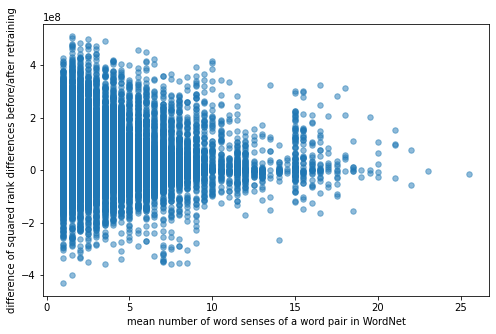

In [124]:
df_before_after_retrain['number_of_word_senses'] = df_before_after_retrain.apply(count_number_wordsenses, axis=1)
df_before_after_retrain = df_before_after_retrain.dropna()
plt.rcParams["figure.figsize"] = (8,5)
plt.scatter(df_before_after_retrain['number_of_word_senses'], df_before_after_retrain['rank_diff_before_and_after_retrain'], alpha=0.5, s=30)
plt.xlabel('mean number of word senses of a word pair in WordNet')
plt.ylabel('difference of squared rank differences before/after retraining')


{'whiskers': [<matplotlib.lines.Line2D at 0x7f5701a645b0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f5701a746a0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f5701a64d90>,
 'medians': [<matplotlib.lines.Line2D at 0x7f5987828130>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f5987828550>,
 'means': []}

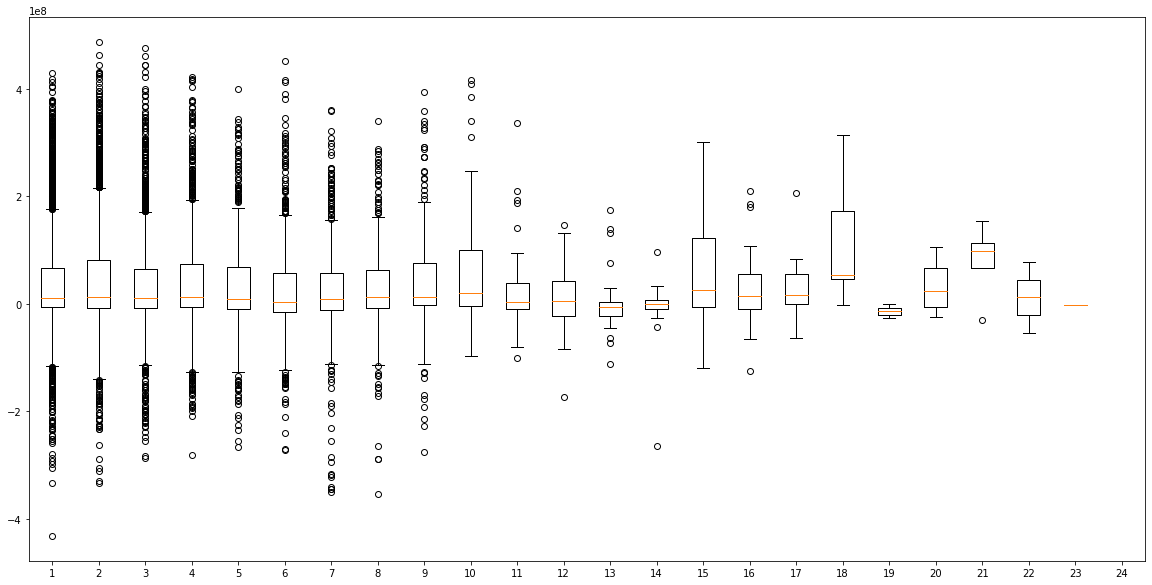

In [130]:
min_number_word_senses = int(df_before_after_retrain['number_of_word_senses'].min())
max_number_word_senses = int(df_before_after_retrain['number_of_word_senses'].max())

fig, axes = plt.subplots(1,1, figsize=(20,10))

df_with_i_word_senses = [df_before_after_retrain[df_before_after_retrain['number_of_word_senses'] == i]['rank_diff_before_and_after_retrain'] for i in range(min_number_word_senses, max_number_word_senses, 1)]
plt.boxplot(df_with_i_word_senses)

In [99]:
pretrained_df['number_of_word_senses'] = pretrained_df.apply(count_number_wordsenses, axis=1)
pretrained_df = pretrained_df.dropna()
%matplotlib inline
plt.scatter(pretrained_df['number_of_word_senses'], pretrained_df['di^2_decontext_bert'], alpha=0.5, s=0.2)
plt.xlabel('mean number of word senses of a word pair in WordNet')
plt.ylabel('spearman squared rank difference')
plt.show()

(array([6.48180e+05, 2.64107e+05, 9.43560e+04, 2.62780e+04, 8.98500e+03,
        3.34200e+03, 7.51000e+02, 1.45000e+02, 2.90000e+01, 8.00000e+00]),
 array([ 1.,  4.,  7., 10., 13., 16., 19., 22., 25., 28., 31.]),
 <BarContainer object of 10 artists>)

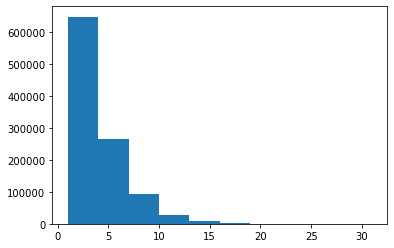

In [105]:
plt.hist(pretrained_df['number_of_word_senses'])

### Categories

In [90]:
train_words = list(pd.read_csv('../fine_tune/train_words.txt', header=None, names=['words'])['words'])

In [91]:
things_database = load_things_database()[['uniqueID', 'Top-down Category (manual selection)']]
things_database

,uniqueID,Top-down Category (manual selection)
0,aardvark,animal
1,abacus,home decor
2,accordion,musical instrument
3,acorn,NaN
4,air_conditioner,electronic device
...,...,...
1849,yoke,NaN
1850,yolk,food
1851,zebra,animal
1852,zipper,NaN


In [92]:
test_df = pd.DataFrame({'uniqueID': train_words}).merge(things_database, on='uniqueID').dropna()

<IPython.core.display.Javascript object>


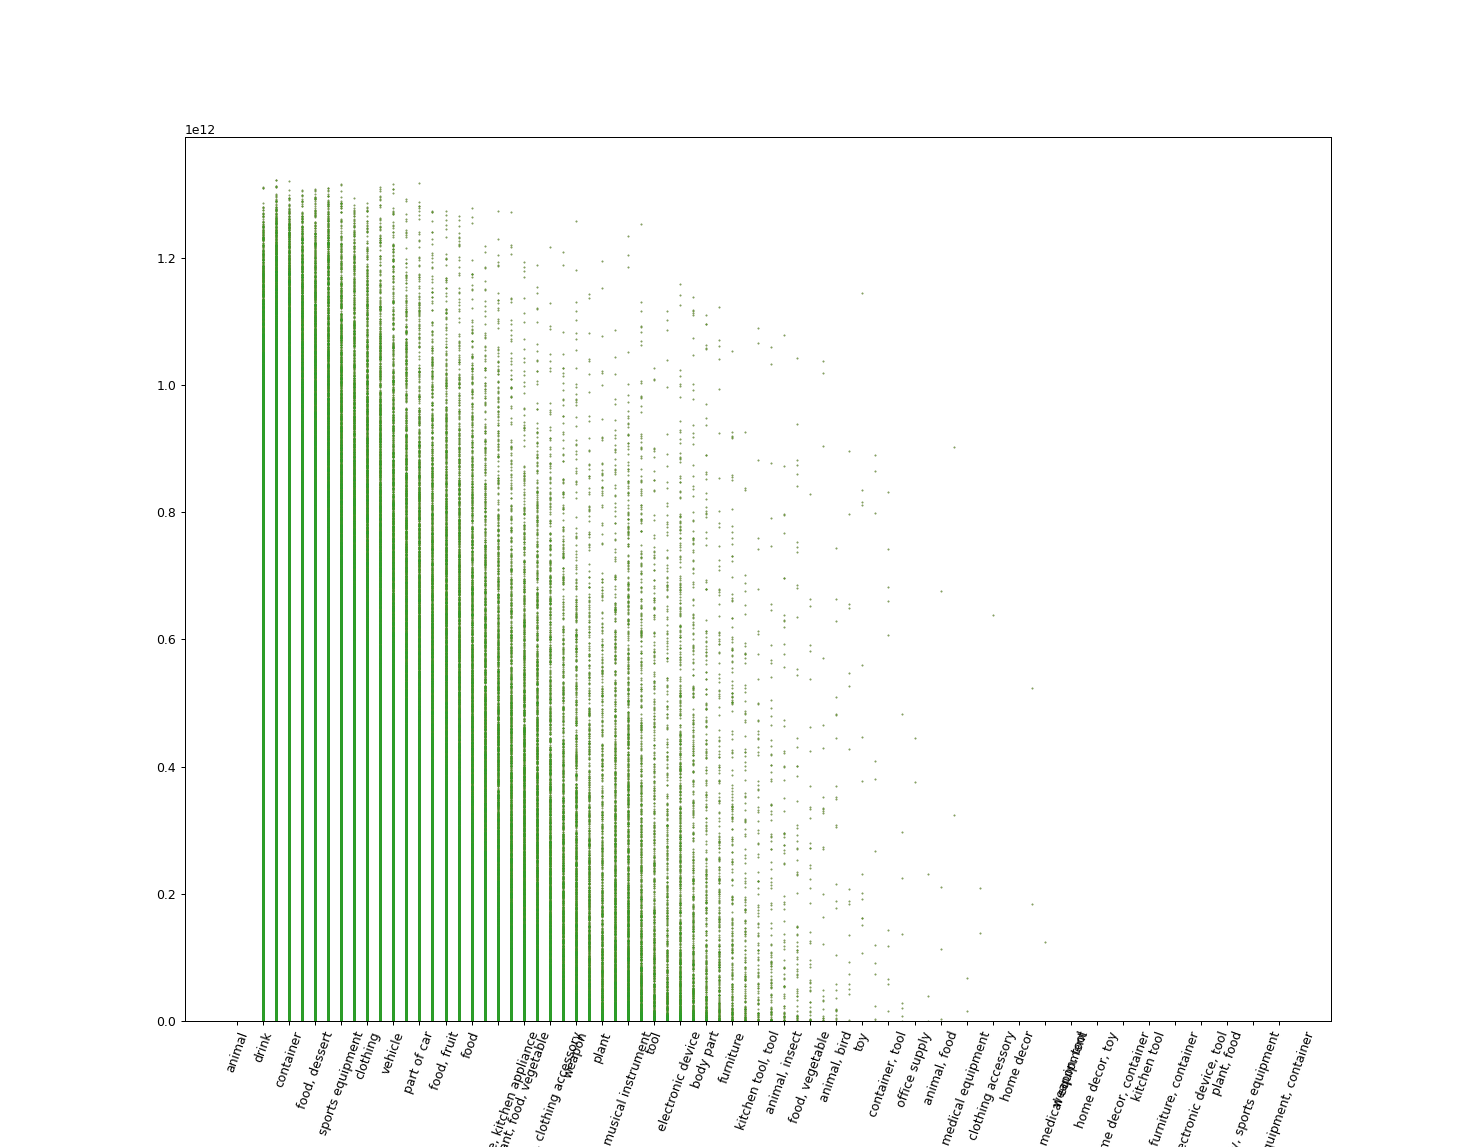

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

In [93]:
%matplotlib notebook
plt.hist(test_df['Top-down Category (manual selection)'])
plt.xticks(rotation=70)

# Simlex

In [31]:
simlex_df = load_simlex()
simlex_df = simlex_df.rename(columns={'human_pred': 'Human Judgement'})

In [32]:
paths = [
    (f'{EMBEDDING_DATA_DIR}/word_sim/static/w2v/word2vec-google-news-300/embeddings.txt', 'Cosine Similarities (Word2Vec)'),
    (f'{EMBEDDING_DATA_DIR}/word_sim/wikidumps/decontext/bert-base/12/word/mean/all/decontext.txt', 'Cosine Similarities (BERT)'),
    (f'{EMBEDDING_DATA_DIR}/word_sim/wikidumps/decontext/gpt-2/12/word/mean/all/decontext.txt', 'Cosine Similarities (GPT-2)'),
]

for path, key in paths:
    evaluation = wordsim_evaluate() 
    embeddings = read_wordsim_embeddings(path, matching='word')
    results = evaluation.evaluate(embeddings)

    pairs_simlex = results['similarity']['simlex']['final_word_pair_list']
    human_pred_simlex = results['similarity']['simlex']['target_list']
    human_pred_simlex = [float(value) for value in human_pred_simlex]

    df = pd.DataFrame({'word1': [pair[0] for pair in pairs_simlex], 
                        'word2': [pair[1] for pair in pairs_simlex], 
                        key: human_pred_simlex})
    simlex_df = simlex_df.merge(df, on=['word1', 'word2'])
    print(simlex_df.columns)

simlex_df = get_ranks(simlex_df)
simlex_df

simlex
ws353
Index(['word1', 'word2', 'Human Judgement', 'Cosine Similarities (Word2Vec)'], dtype='object')
simlex
ws353
Index(['word1', 'word2', 'Human Judgement', 'Cosine Similarities (Word2Vec)',
       'Cosine Similarities (BERT)'],
      dtype='object')
simlex
ws353
Index(['word1', 'word2', 'Human Judgement', 'Cosine Similarities (Word2Vec)',
       'Cosine Similarities (BERT)', 'Cosine Similarities (GPT-2)'],
      dtype='object')


,word1,word2,Human Judgement,Cosine Similarities (Word2Vec),Cosine Similarities (BERT),Cosine Similarities (GPT-2),human_rank,embedding_rank_w2v,embedding_rank_bert,embedding_rank_gpt,di^2_w2v,di^2_decontext_bert,di^2_decontext_gpt
0,old,new,1.58,0.222780,0.627116,0.998834,173.0,209.0,489.0,899.0,1296.00,99856.00,527076.00
1,smart,intelligent,9.20,0.649528,0.735464,0.990492,980.0,918.0,819.0,105.0,3844.00,25921.00,765625.00
2,hard,difficult,8.77,0.602575,0.787701,0.986603,948.0,885.0,916.0,63.0,3969.00,1024.00,783225.00
3,happy,cheerful,9.55,0.383774,0.774201,0.995947,993.5,510.0,903.0,352.0,233772.25,8190.25,411522.25
4,hard,easy,0.95,0.470963,0.754517,0.996050,102.0,706.0,863.0,366.0,364816.00,579121.00,69696.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,join,acquire,2.85,0.262319,0.638624,0.996286,302.5,278.0,525.0,402.0,600.25,49506.25,9900.25
995,send,attend,1.67,0.313500,0.662590,0.996350,186.5,381.0,626.0,410.0,37830.25,193160.25,49952.25
996,gather,attend,4.80,0.332902,0.681442,0.995317,522.0,422.0,693.0,290.0,10000.00,29241.00,53824.00
997,absorb,withdraw,2.97,0.216904,0.629507,0.996108,313.5,197.0,499.0,375.0,13572.25,34410.25,3782.25


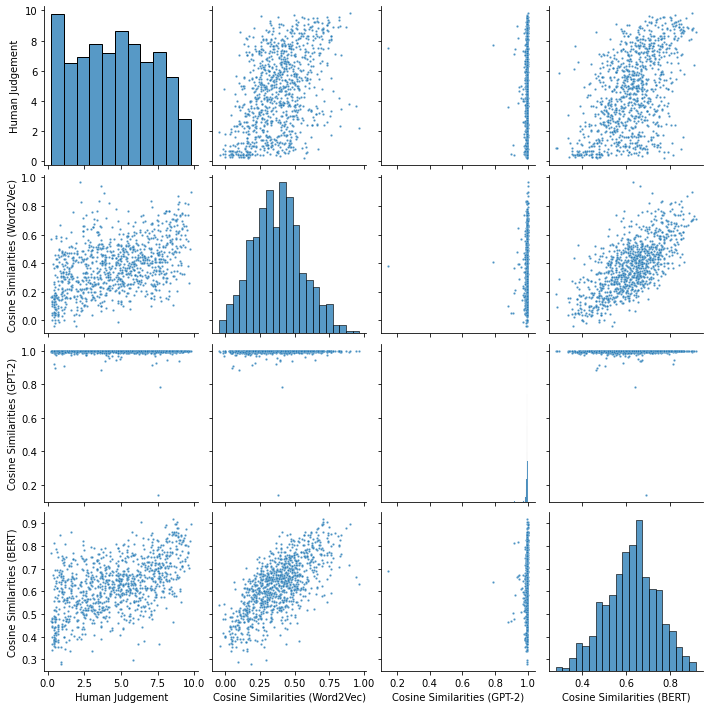

In [33]:
plot(simlex_df, 'simlex_pretrained', 0.8, 5)

# Wordsim

In [34]:
evaluation = wordsim_evaluate() 
context_path = f'{EMBEDDING_DATA_DIR}/word_sim/static/w2v/word2vec-google-news-300/embeddings.txt'
embeddings = read_wordsim_embeddings(context_path, matching='word')
results = evaluation.evaluate(embeddings)
pairs_wordsim = results['similarity']['ws353']['final_word_pair_list']
human_pred_wordsim = results['similarity']['ws353']['gold_list']
human_pred_wordsim = [float(value) for value in human_pred_wordsim]

wordsim_df = pd.DataFrame({'word1': [pair[0] for pair in pairs_wordsim], 
                           'word2': [pair[1] for pair in pairs_wordsim], 
                           'Human Judgement': human_pred_wordsim})
wordsim_df = get_ranks(wordsim_df)

simlex
ws353


# Analysis of cosine similarity values

## With homonyms

In [94]:
pretrained_df

,word1,word2,Human Judgement,Cosine Similarities (BERT),Cosine Similarities (Word2Vec),Cosine Similarities (GPT-2),human_rank,embedding_rank_w2v,embedding_rank_bert,embedding_rank_gpt,di^2_w2v,di^2_decontext_bert,di^2_decontext_gpt
0,aardvark,abacus,0.082239,0.620734,0.259076,0.997712,8739.0,1031611.0,1115966.0,1037666.0,1.046267e+12,1.225952e+12,1.058691e+12
1,aardvark,accordion,0.102209,0.312072,0.184559,0.995882,67010.0,840009.0,37694.0,688624.0,5.975275e+11,8.594279e+08,3.864040e+11
2,aardvark,acorn,0.489478,0.677677,0.282932,0.998081,917322.0,1064269.0,1147530.0,1093928.0,2.159342e+10,5.299572e+10,3.118968e+10
3,aardvark,airbag,0.103483,0.478791,0.050837,0.992891,72362.0,182833.0,737961.0,280186.0,1.220384e+10,4.430220e+11,4.319081e+10
4,aardvark,airplane,0.165536,0.470848,0.153453,0.987064,303839.0,709113.0,697913.0,42086.0,1.642470e+11,1.552943e+11,6.851463e+10
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1157476,yolk,zipper,0.082522,0.326827,0.216152,0.993408,9117.0,940711.0,57978.0,330589.0,8.678674e+11,2.387397e+09,1.033442e+11
1157477,yolk,zucchini,0.817020,0.590721,0.343364,0.997356,1116256.0,1113765.0,1080008.0,973297.0,6.205081e+06,1.313918e+09,2.043728e+10
1157478,zebra,zipper,0.109019,0.508280,0.185451,0.993739,96679.0,843361.0,867699.0,367199.0,5.575340e+11,5.944718e+11,7.318107e+10
1157479,zebra,zucchini,0.280376,0.368386,0.202232,0.997541,583005.0,900398.0,165417.0,1007594.0,1.007383e+11,1.743797e+11,1.802758e+11


In [96]:
embedding_sim_col = 'Cosine Similarities (BERT)'
pretrained_df.sort_values(embedding_sim_col, ascending=False).head(50)[['word1', 'word2', embedding_sim_col]]

,word1,word2,Cosine Similarities (BERT)
292211,camera1,camera2,1.000000
924578,mold1,mold2,1.000000
104055,bat1,bat2,1.000000
371850,chest1,chest2,1.000000
1124585,stamp1,stamp2,1.000000
1140090,tank1,tank2,1.000000
503685,crystal1,crystal2,1.000000
273696,button1,button2,1.000000
787251,hook1,hook2,1.000000
1087356,screen1,screen2,1.000000


In [108]:
def calc_cosine_diff(row):
    sim_before = 'Similarity Before Retrain'
    sim_after = 'Similarity After Retrain'
    return abs(row[sim_before] - row[sim_after])

df_before_after_retrain['cosine_diff'] = df_before_after_retrain.apply(calc_cosine_diff, axis=1)

In [113]:
df_before_after_retrain.sort_values(by='cosine_diff', ascending=False).head(30)[['word1', 'word2', 'cosine_diff']]

,word1,word2,cosine_diff
9437,cow,penguin,0.612219
3447,bologna,quesadilla,0.595317
3377,bologna,green_beans,0.595314
3408,bologna,mashed_potato,0.587995
3482,bologna,spinach,0.586250
19518,pickle,sickle,0.585088
3346,bologna,cornmeal,0.579264
3328,bologna,cabbage,0.577577
3491,bologna,sweet_potato,0.565183
13562,grits,recliner,0.565076
